In [1]:
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-white'])
from mpl_toolkits.mplot3d import Axes3D

from random import random

import numpy as np

import mlgrad.model as model
import mlgrad.func as func
import mlgrad.avragg as avragg
import mlgrad.regular as regular
import mlgrad.loss as loss
import mlgrad.weights as weights
import mlgrad.averager as averager

from mlgrad import averager_it, averager_fg, fg, erm_fg, sg, erm_sg, irgd, erm_irgd, erisk, mrisk

In [2]:
loss_func_sq = loss.ErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())
loss_func_sqrt = loss.ErrorLoss(func.Sqrt(1.0))
loss_func_logsq = loss.ErrorLoss(func.LogSquare(1.0))

In [3]:
def sigma_neuron_layer2(n_input, n_output):
    outfunc = func.Arctang()
    layer = model.SigmaNeuronModelLayer(outfunc, n_input, n_output)
    return layer

In [4]:
def create_nn(n_input, n_hidden):
    layer1 = sigma_neuron_layer2(n_input, n_hidden)

    body = model.FFNetworkModel()
    body.add(layer1)

    head = model.LinearModel(n_hidden)
    ffnn = model.FFNetworkFuncModel(head, body)
    ffnn.allocate()
    return ffnn

In [5]:
def generate_nn(n_input, n_hidden):
    nn_orig = create_nn(n_input, n_hidden)
    layer = nn_orig.body.layers[0]
    layer_param = layer.param[:]
    n = len(layer_param)
    random_param = 4*np.random.random(n)-2
    for i in range(n):
        layer_param[i] = random_param[i]
    head_param = nn_orig.head.param[:]
    head_param[0] = 0.
    for i in range(n_hidden):
        head_param[i+1] = (-1.)**i #/((i+1.))
    return nn_orig


In [6]:
result = {}

n_input = 2
n_hidden = 7

In [7]:
nn_orig = generate_nn(n_input, n_hidden)
print(nn_orig.param.base)

[ 0.          1.         -1.          1.         -1.          1.
 -1.          1.         -1.70181833  1.85668315  1.26164151  0.10731504
 -1.2465464  -1.84924528 -1.28878868 -0.90901411 -1.27384255  1.83435945
 -1.31679844 -1.42047526  1.94303901  0.69467854  1.20450621  1.62652002
 -0.90425216 -0.11866651 -0.93337692  1.19978006 -0.45223336]


In [8]:
Q = 45
q = Q / 100.

N = 50
M = int(q*N*N)

7.47855266464299


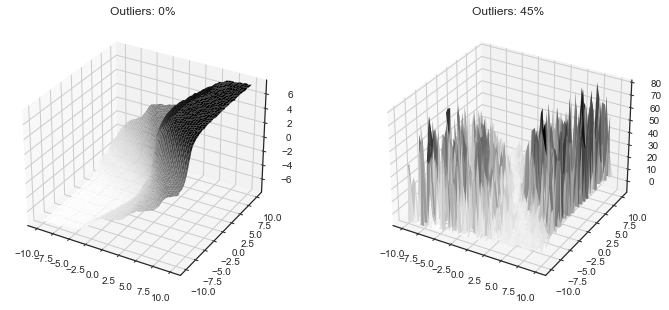

In [9]:
xrange = np.linspace(-10., 10., N)
yrange = np.linspace(-10., 10., N)
xxrange, yyrange= np.meshgrid(xrange, yrange, indexing='xy')
#iirange, jjrange= np.meshgrid(xrange, yrange, indexing='ij')
X = np.c_[xxrange.ravel(), yyrange.ravel()]
Y = np.array(nn_orig.evaluate_all(X))
Y_s = Y + 0.1*(2*np.random.random(N*N)-1)
print(np.max(Y))
YY = Y_s.reshape(xxrange.shape)
I = np.random.permutation(np.arange(0,N*N))[:M]
Y_o = Y_s.copy()
for i in I:
    yi = Y_o[i]
    s = random()
    Y_o[i] += s * abs(yi) * 10
YY_o = Y_o.reshape(xxrange.shape)

# plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
# cb1 = plt.imshow(YY, extent=(-7.,7.,-7.,7.), origin='bottom', interpolation='none')
# plt.colorbar(cb1)
# plt.subplot(1,2,2)
# cb2 = plt.imshow(YY_o, extent=(-7.,7.,-7.,7.), origin='bottom', interpolation='none')
# plt.colorbar(cb2)
# plt.show()

plt.figure(figsize=(12,5))
fig = plt.gcf()
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(xxrange, yyrange, YY, cmap=plt.cm.Greys)
plt.title("Outliers: 0%")
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(xxrange, yyrange, YY_o, cmap=plt.cm.Greys)
plt.title("Outliers: %s%%" % Q)
# plt.savefig(r"fig/isnn2019_surfplot_%s_%s.eps" % (n_input, n_hidden))
plt.show()

In [10]:
n_param = nn_orig.n_param
nn_bp = create_nn(n_input, n_hidden)
nn_bp.param[:] = np.random.random(n_param)
nn_bp_o = create_nn(n_input, n_hidden)
nn_bp_o.param[:] = np.random.random(n_param)
nn_sqrt_o = create_nn(n_input, n_hidden)
nn_sqrt_o.param[:] = np.random.random(n_param)
nn_logsq_o = create_nn(n_input, n_hidden)
nn_logsq_o.param[:] = np.random.random(n_param)
nn_wm_o = create_nn(n_input, n_hidden)
nn_wm_o.param[:] = np.random.random(n_param)
nn_m_o = create_nn(n_input, n_hidden)
nn_m_o.param[:] = np.random.random(n_param)

In [11]:
# er_bp = erisk(X, Y_s, nn_bp, loss_func_sq)
# fg_bp = erm_fg(er_bp, h=0.001, tol=1.0e-8, verbose=0, n_restart=5)

# plt.plot(fg_bp.lvals)
# plt.show()

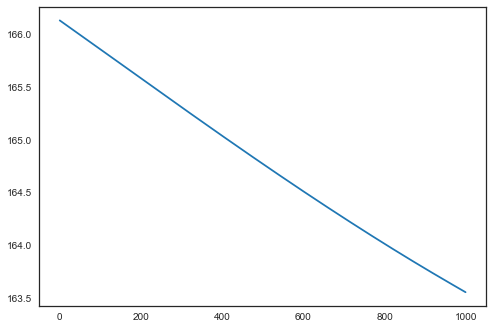

In [12]:
er_bp_o = erisk(X, Y_o, nn_bp_o, loss_func_sq)
fg_bp_o = erm_fg(er_bp_o, h=0.001, tol=1.0e-8, verbose=0, n_restart=5)

plt.plot(fg_bp_o.lvals)
plt.show()

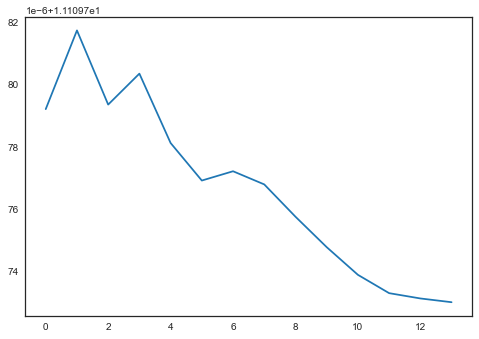

In [13]:
er_sqrt_o = erisk(X, Y_o, nn_sqrt_o, loss_func_sqrt)
fg_sqrt_o = erm_fg(er_sqrt_o, h=0.001, tol=1.0e-8, verbose=0, n_restart=5)

plt.plot(fg_sqrt_o.lvals)
plt.show()

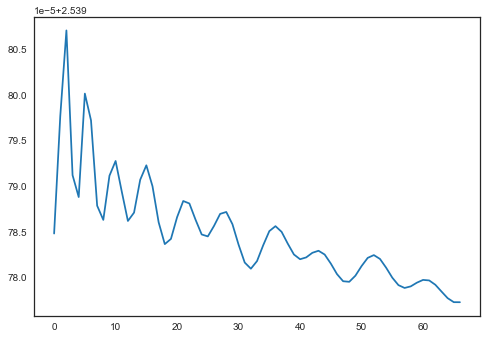

In [14]:
er_logsq_o = erisk(X, Y_o, nn_logsq_o, loss_func_logsq)
fg_logsq_o = erm_fg(er_logsq_o, h=0.001, tol=1.0e-8, verbose=0, n_restart=5)

plt.plot(fg_logsq_o.lvals)
plt.show()

In [15]:
er_wm_o = erisk(X, Y_o, nn_wm_o, loss_func_sq)
fg_wm_o = fg(er_wm_o, h=0.001, tol=1.0e-9, n_iter=1000)
alpha = 0.99-q
avg_wm_o = averager_it(func.Quantile_Sqrt(alpha, 0.001))
avg_wm_o = avragg.WMAverage(avg_wm_o)
wg_wm_o = weights.MWeights(avg_wm_o, er_wm_o)

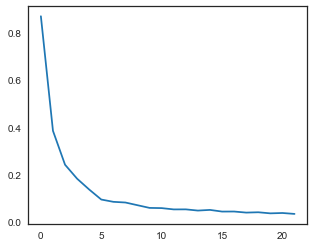

In [16]:
irgd_wm_o = erm_irgd(fg_wm_o, wg_wm_o, n_iter=22)

plt.figure(figsize=(5,4))
plt.plot(irgd_wm_o.lvals)
plt.show()

In [1]:
avg22 = averager_it(func.Quantile_Sqrt(alpha, 0.001))
avg22 = avragg.WMAverage(avg22)
mr2 = mrisk(X, Y_o, nn_m_o, loss_func_sq, avg22)
alg_fg2 = erm_fg(mr2, h=0.001, n_iter=1000, tol=1.0e-9, n_restart=5 )

plt.figure(figsize=(10,4))
plt.plot(alg_fg2.lvals)
plt.show()

NameError: name 'averager_it' is not defined

In [24]:
result[Q] = {
    'nn':(
        nn_bp_o, nn_sqrt_o, nn_logsq_o, nn_wm_o, nn_m_o),
    'title':(
        'BP | %s%%' % Q,
        'BP $\sqrt{1+x^2}$ | %s%%' % Q,
        'BP $\ln(1+x^2)$ | %s%%' % Q,
        'WM-BP | %s%%' % Q,
        'M-BP | %s%%' % Q,
    ),
    'b':0.1
}

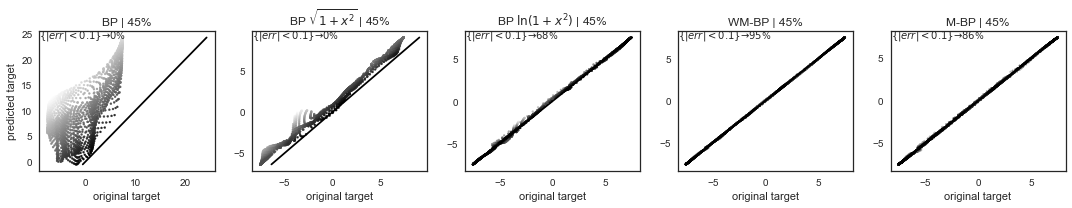

In [25]:
K = 5
m_q = len(result)
plt.figure(figsize=(K*3.0, m_q * 3))
for j, Q in enumerate(result):
    for i in range(K):
        current = result[Q]
        b = current['b']
        plt.subplot(m_q, K, K*j+i+1)
        _ffnn = current['nn'][i]
        Y1 = np.array(_ffnn.evaluate_all(X))
        title = current['title'][i]
        plt.title(title)
        V = np.abs(Y-Y1)
        I = np.argsort(V)
        I = I[::-1]
        Y2 = [np.min(Y1), np.max(Y1)]
        plt.plot(Y2, Y2, c='k')
        plt.scatter(Y[I], Y1[I], c=V[I], s=4, cmap=plt.cm.gray)
        c = sum(V < b) / len(V) * 100
        y_min, y_max = plt.xlim()
        plt.text(y_min, Y1.max(), r'$\{|err|<%.1f\}\to%s$%%' % (b, int(c)))
        if i == 0:
            plt.ylabel("predicted target")
        if j == m_q-1:
            plt.xlabel("original target")
        if j < m_q-1:
            plt.xticks([], [])
        plt.minorticks_on()
plt.tight_layout()
plt.savefig(r"fig/isnn2019_regr_%s_%s.eps" % (n_input, n_hidden))
plt.show()

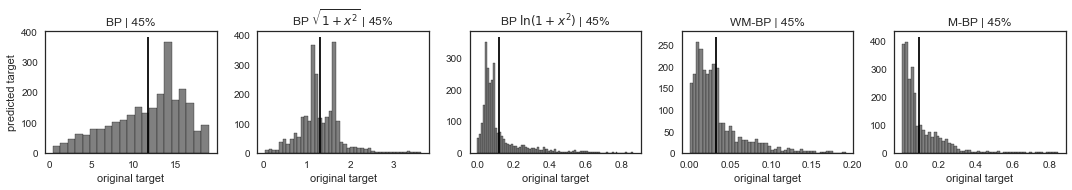

In [20]:
K = 5
m_q = len(result)
plt.figure(figsize=(K*3.0, m_q * 2.75))
for j, Q in enumerate(result):
    for i in range(K):
        current = result[Q]
        b = current['b']
        plt.subplot(m_q, K, K*j+i+1)
        _ffnn = current['nn'][i]
        Y1 = np.array(_ffnn.evaluate_all(X))
        title = current['title'][i]
        plt.title(title)
        V = np.abs(Y-Y1)
        I = np.argsort(V)
        I = I[::-1]
        #Y2 = [np.min(Y1), np.max(Y1)]
        #plt.plot(Y2, Y2, c='k')
        #plt.scatter(Y[I], Y1[I], c=V[I], s=4, cmap=plt.cm.gray)
        plt.hist(V, bins="auto", color='grey', edgecolor='k')
        _, h_max = plt.ylim()
        plt.vlines(np.mean(V), 0, h_max, colors='k')
        c = sum(V < b) / len(V) * 100
        y_min, y_max = plt.xlim()
        #plt.text(y_min, Y1.max(), r'$\{|err|<%.1f\}\to%s$%%' % (b, int(c)))
        if i == 0:
            plt.ylabel("predicted target")
        if j == m_q-1:
            plt.xlabel("original target")
        if j < m_q-1:
            plt.xticks([], [])
        plt.minorticks_on()
plt.tight_layout()
plt.savefig(r"fig/isnn2019_regr_hist_%s_%s.eps" % (n_input, n_hidden))
plt.show()

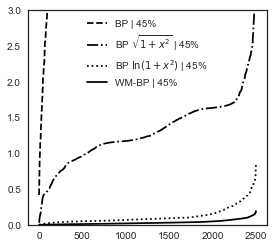

In [21]:
K = 4
m_q = len(result)
lstyles = ['--', '-.', ':', '-']
plt.figure(figsize=(4.0, 3.5))
current = result[Q]
b = current['b']
for i in range(K):
    _ffnn = current['nn'][i]
    Y1 = np.array(_ffnn.evaluate_all(X))
    title = current['title'][i]
    #plt.title(title)
    V = np.abs(Y-Y1)
    Vs = np.sort(V)
    plt.plot(Vs, c='k', linestyle=lstyles[i], label = title)
plt.tight_layout()
plt.ylim(0, 3.0)
plt.legend()
plt.savefig(r"fig/isnn2019_regr_err_%s_%s." % (n_input, n_hidden))
plt.show()